In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable

from scipy.integrate import quad
from scipy.optimize import brentq
import numpy as np

from tqdm.notebook import tqdm
import pandas as pd
from scipy import interpolate

# integrand

In [2]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)

# Graph

In [3]:
R_um = {}
R0_um = {}
R_dm = {}
R0_dm = {}
RP_um = {}
RPl_um = {}
Ks_um = {}
Ks_dm = {}
K_mins = {}

In [4]:
K_ = np.linspace(0,10,1001)
m_ = np.linspace(0,10,1001)

In [5]:
def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=200)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan


In [153]:
def get_K_r_rp_full(m):
    Xs1 = np.logspace(-15,-3,2000)
    Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

    R_ls = []
    R_drs = []


    for X in Xs:
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        R_ls.append(R_l)
        R_drs.append(R_dr)


    R0 = np.array(R_ls)
    RD = 2*np.array(R_drs)
    R = R0 -RD
    KK = 1/(R/Xs)
    K_min_arg = np.argmin(KK)

    K_d = KK[:K_min_arg]
    K_u = KK[K_min_arg:]
    r_d = Xs[:K_min_arg]/K_d
    r_u = Xs[K_min_arg:]/K_u
    R_0d = R0[:K_min_arg]
    R_0u = R0[K_min_arg:]
    R_dd = -RD[:K_min_arg]
    R_du = -RD[K_min_arg:]

    R_u = R_0u + R_du
    R_d = R_0d + R_dd
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]
    Xsd = Xs[:K_min_arg]

    a = 1/np.sqrt(Xsu*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPS = b*Xsu


    a = 1/np.sqrt(Xsd*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPSd = b*Xsd


    RP1_d = []
    RP1_u = []
    RPl_d = []
    RPl_u = []
    K1p = []

    for K, r, r0, OP in zip(K_u, R_u, R_0u, OPS):
        # 1. 적당한 간격으로 샘플
        rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
        diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


        # 2. sign change 구간 찾기 (교점 후보)
        sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]

        try:
            # 첫 번째 교점
            i1 = sign_change[0]
            if len(sign_change) == 1:
                rp_left = 0
                RP1_d.append(0)
                RPl_d.append(0)
                
            else:
                rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
                RP1_d.append(rp_left)
                RPl_d.append(RP_l(rp_left, K, r0, OP, m))


                
            # 두 번째 교점
            i2 = sign_change[-1]
            rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

            RP1_u.append(rp_right)
            RPl_u.append(RP_l(rp_right, K, r0, OP, m))
            K1p.append(K)
        except:
            K1p.append(K)
            RP1_d.append(np.nan)
            RP1_u.append(np.nan)
            RPl_d.append(np.nan)
            RPl_u.append(np.nan)


    K1p = np.array(K1p)
    RP1_u = np.array(RP1_u)
    RPl_u = np.array(RPl_u)
    RP1_d = np.array(RP1_d)
    RPl_d = np.array(RPl_d)


    arg, = np.where(RP1_u<1e-13)
    K1p[arg] = np.nan
    RPl_u[arg] = np.nan
    RP1_u[arg] = np.nan
    RPl_d[arg] = np.nan
    RP1_d[arg] = np.nan
    return R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start


In [166]:
R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start = get_K_r_rp_full(4)

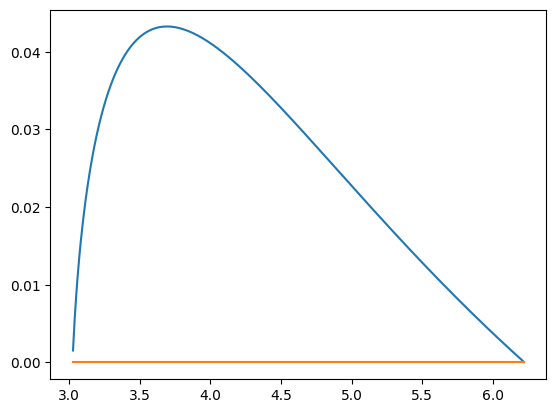

In [167]:
# plt.plot(K1p,R_u)
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)

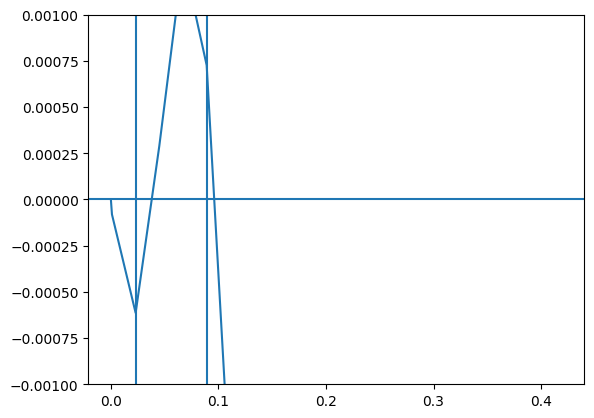

In [175]:
K = 4
m = 6
# rs = np.linspace(0,1,10000)[1:]

Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    if m !=0:
        R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    else:
        R_dr = 0
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd



F_Ru = interpolate.interp1d(K_u,R_u,kind='linear',bounds_error=False,fill_value=np.nan)
F_R0u = interpolate.interp1d(K_u,R_0u,kind='linear',bounds_error=False,fill_value=np.nan)
F_OPS = interpolate.interp1d(K_u,OPS,kind='linear',bounds_error=False,fill_value=np.nan)

F_Rd = interpolate.interp1d(K_d,R_d,kind='linear',bounds_error=False,fill_value=np.nan)
F_R0d = interpolate.interp1d(K_d,R_0d,kind='linear',bounds_error=False,fill_value=np.nan)



Ku_ = K_[K_>=K_start] 



RP1_d = []
RP1_u = []
RPl_d = []
RPl_u = []
K1p = []
num = 0
diff_lists = []

for K in K_[K_<K_start]:
    RP1_d.append(np.nan)
    RP1_u.append(np.nan)
    RPl_d.append(np.nan)
    RPl_u.append(np.nan)
    K1p.append(K)
for K, r, r0, OP in zip(Ku_, F_Ru(Ku_), F_R0u(Ku_), F_OPS(Ku_)):
    # 1. 적당한 간격으로 샘플
    rps = np.r_[np.logspace(-12, -3, 20), np.linspace(0.001, (1 - r0) / 2, 20)]
    diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
    diff_lists.append(len(sign_change))
    try:
        # 첫 번째 교점
            
        i1 = sign_change[0]
        # sol = root_scalar(RP_diff, bracket=(rps[i1],rps[i1+1]), args=(K,r0,OP,m), method='toms748', xtol=1e-6, rtol=1e-6, maxiter=200)
        # r_star = sol.root if sol.converged else np.nan
        if len(sign_change) == 1:
            rp_left = 0
            RP1_d.append(0)
            RPl_d.append(0)
            
        else:
            rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
            RP1_d.append(rp_left)
            RPl_d.append(RP_l(rp_left, K, r0, OP, m))
            
        # rp_left = r_star

        # 두 번째 교점
        i2 = sign_change[-1]
        # sol = root_scalar(RP_diff, bracket=(rps[i2-1],rps[i2+1]), args=(K,r0,OP,m), method='toms748', xtol=1e-6, rtol=1e-6, maxiter=200)
        # r_star = sol.root if sol.converged else np.nan
        
        rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))
        # rp_right = r_star

        RP1_u.append(rp_right)

        # RP값도 같이 저장
        
        RPl_u.append(RP_l(rp_right, K, r0, OP, m))
        K1p.append(K)
    except:
        K1p.append(K)
        RP1_d.append(np.nan)
        RP1_u.append(np.nan)
        RPl_d.append(np.nan)
        RPl_u.append(np.nan)
    if num == 0:
        plt.plot(rps,diffs)
        for i in sign_change:
            plt.axvline(rps[i])
        plt.axhline(0)
        plt.ylim(-1e-3,1e-3)
        num += 1

K1p = np.array(K1p)
RP1_u = np.array(RP1_u)
RPl_u = np.array(RPl_u)
RP1_d = np.array(RP1_d)
RPl_d = np.array(RPl_d)


arg, = np.where(RP1_u<1e-4)
K1p[arg] = np.nan
RPl_u[arg] = np.nan
RP1_u[arg] = np.nan
RPl_d[arg] = np.nan
RP1_d[arg] = np.nan



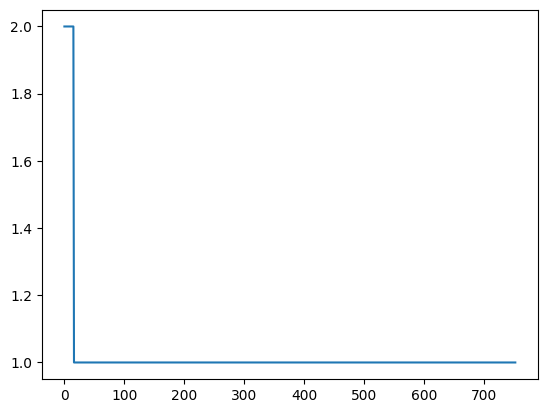

In [176]:
plt.plot(diff_lists)

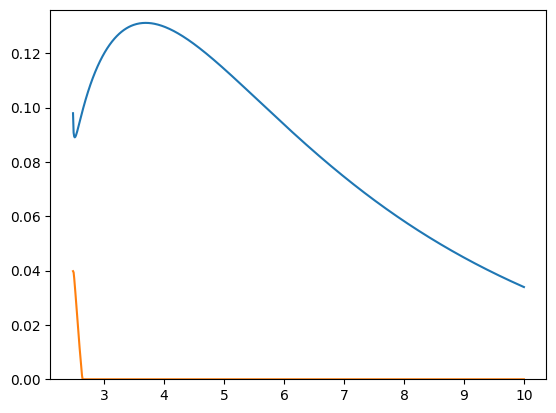

In [177]:
# plt.plot(K1p,np.where(np.abs(RP1_d-RP1_u)>1e-7,RP1_d,np.nan))
plt.plot(K1p,RP1_u)
plt.ylim(0,)
plt.plot(K1p,RP1_d)
# plt.xscale('log')

In [178]:
def get_K_r_rp(m,K_):
    Xs1 = np.logspace(-15,-3,2000)
    Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

    R_ls = []
    R_drs = []


    for X in Xs:
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        if m !=0:
            R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        else:
            R_dr = 0
        R_ls.append(R_l)
        R_drs.append(R_dr)


    R0 = np.array(R_ls)
    RD = 2*np.array(R_drs)
    R = R0 -RD
    KK = 1/(R/Xs)
    K_min_arg = np.argmin(KK)

    K_d = KK[:K_min_arg]
    K_u = KK[K_min_arg:]
    r_d = Xs[:K_min_arg]/K_d
    r_u = Xs[K_min_arg:]/K_u
    R_0d = R0[:K_min_arg]
    R_0u = R0[K_min_arg:]
    R_dd = -RD[:K_min_arg]
    R_du = -RD[K_min_arg:]

    R_u = R_0u + R_du
    R_d = R_0d + R_dd
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]
    Xsd = Xs[:K_min_arg]

    a = 1/np.sqrt(Xsu*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPS = b*Xsu


    a = 1/np.sqrt(Xsd*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPSd = b*Xsd

    F_Ru = interpolate.interp1d(K_u,R_u,kind='linear',bounds_error=False,fill_value=np.nan)
    F_R0u = interpolate.interp1d(K_u,R_0u,kind='linear',bounds_error=False,fill_value=np.nan)
    F_OPS = interpolate.interp1d(K_u,OPS,kind='linear',bounds_error=False,fill_value=np.nan)

    Ku_ = K_[K_>=K_start] 

    if m == 0:
        return F_Ru(K_),F_R0u(K_),np.nan*np.ones_like(K_),np.nan*np.ones_like(K_)

    RP1_d = []
    RP1_u = []
    RPl_d = []
    RPl_u = []
    K1p = []

    for K in K_[K_<K_start]:
        RP1_d.append(np.nan)
        RP1_u.append(np.nan)
        RPl_d.append(np.nan)
        RPl_u.append(np.nan)
        K1p.append(K)
    for K, r, r0, OP in zip(Ku_, F_Ru(Ku_), F_R0u(Ku_), F_OPS(Ku_)):
        # 1. 적당한 간격으로 샘플
        rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
        diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


        # 2. sign change 구간 찾기 (교점 후보)
        sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]

        try:
            # 첫 번째 교점
            i1 = sign_change[0]
            if len(sign_change) == 1:
                rp_left = 0
                RP1_d.append(0)
                RPl_d.append(0)
                
            else:
                rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
                RP1_d.append(rp_left)
                RPl_d.append(RP_l(rp_left, K, r0, OP, m))

            # 두 번째 교점
            i2 = sign_change[-1]
            rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))


            RP1_u.append(rp_right)

            # RP값도 같이 저장

            RPl_u.append(RP_l(rp_right, K, r0, OP, m))
            K1p.append(K)
        except:
            K1p.append(K)
            RP1_d.append(np.nan)
            RP1_u.append(np.nan)
            RPl_d.append(np.nan)
            RPl_u.append(np.nan)


    K1p = np.array(K1p)
    RP1_u = np.array(RP1_u)
    RPl_u = np.array(RPl_u)
    RP1_d = np.array(RP1_d)
    RPl_d = np.array(RPl_d)
    

    arg, = np.where(RP1_u<1e-13)
    K1p[arg] = np.nan
    RPl_u[arg] = np.nan
    RP1_u[arg] = np.nan
    RPl_d[arg] = np.nan
    RP1_d[arg] = np.nan
    R_u = F_Ru(K_)
    R0_u = F_R0u(K_)
    OPS_u = F_OPS(K_)
    R_u,R_0u = F_Ru(K_),F_R0u(K_)
    return R_u,R_0u,RP1_u,RPl_u


In [207]:
K_ = np.linspace(0,10,101)
m_ = np.linspace(0,10,101)
R_us = []
R_0us = []
RP1_us = []
RPl_us = []
for m in tqdm(m_):
    R_u,R_0u,RP1_u,RPl_u = get_K_r_rp(m,K_)
    R_us.append(R_u)
    R_0us.append(R_0u)
    RP1_us.append(RP1_u)
    RPl_us.append(RPl_u)


  0%|          | 0/101 [00:00<?, ?it/s]

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/2943725743.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  a = 1/np.sqrt(X*m)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/2943725743.py:11: RuntimeWarning: invalid value encountered in scalar subtract
  b = 4/np.pi * a - 0.3056*a**3
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/2943725743.py:45: RuntimeWarning: divide by zero encountered in divide
  a = 1/np.sqrt(Xsu*m)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/2943725743.py:46: RuntimeWarning: invalid value encountered in subtract
  b = 4/np.pi * a - 0.3056*a**3
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/2943725743.py:51: RuntimeWarning: divide by zero encountered in divide
  a = 1/np.sqrt(Xsd*m)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/2943725743.py:52: RuntimeWarning: invalid value encountered in subtract
  b = 4/np.pi * a - 0.3056*a**3


In [326]:
Ks = np.linspace(0,10,1001)
KL = []

for m in np.linspace(4,9,11):
    R_u,R_0u,RP1_u,RPl_u = get_K_r_rp(m,Ks)
    KL.append(np.min(Ks[~np.isnan(RP1_u)]))


/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_69480/3468341370.py:11: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_69480/3468341370.py:29: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)


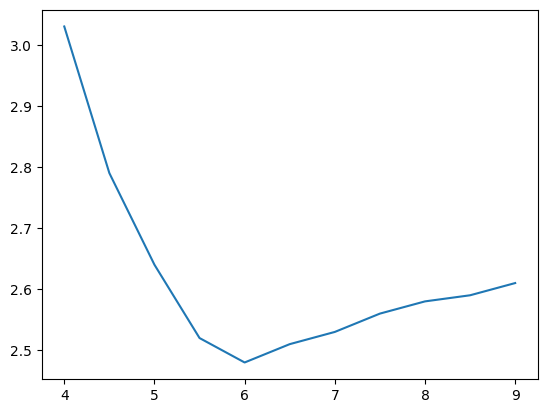

In [327]:
plt.plot(np.linspace(4,9,11),KL)

In [308]:
MCS_rp0 = np.load('mcs_rp0.npz')
Ks_d_rp0 = MCS_rp0['K_d']
Ks_u_rp0 = MCS_rp0['K_u']
ms_rp0 = MCS_rp0['ms']

MCS_rd = np.load('mcs_Rd.npz')
Ks_d_rd = MCS_rd['K_d']
Ks_u_rd = MCS_rd['K_u']
ms_rd = MCS_rd['ms']


MCS_rpl0 = np.load('mcs_rpl0.npz')
Ks_d_rpl0 = MCS_rpl0['K_d']
Ks_u_rpl0 = MCS_rpl0['K_u']
ms_rpl0 = MCS_rpl0['ms']

In [180]:
m = 3.9
ms = np.linspace(3.8,10,621)
# @parfor(ms)
def get_Kritical_0(m):
# rs = np.linspace(0,1,10000)[1:]
    Xs1 = np.logspace(-15,-3,2000)
    Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]


    R0 = np.nan*np.zeros(len(Xs)) # R_0: Lock state oscillator
    RDh = np.nan*np.zeros(len(Xs)) # R_D: Drift oscillators
    OPS = np.nan*np.zeros(len(Xs)) # O_p: Peak frequency of driven oscillator
    
    # Calulate $r_0$ and $r_D$
    for i,X in enumerate(Xs):
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        OPS[i] = omega_p


    RD = 2*RDh
    R = R0 -RD
    KK = Xs/R
    K_min_arg = np.argmin(KK)
    K_u = KK[K_min_arg:]
    r_u = Xs[K_min_arg:]/K_u
    R_0u = R0[K_min_arg:]
    R_du = -RD[K_min_arg:]
    OPSu = OPS[K_min_arg:]

    R_u = R_0u + R_du
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]

    RPS = []
    RP0s = []
    K1p = []
    
    for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
        omega_pp = X
        rp = 1e-16
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = b*K*rp

        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
        RP = (RP_ls-RP_ds)
        RPS.append(RP)
    RPS = np.array(RPS)
    x, = np.where(RPS-rp>=0)
    # x, = np.where(RPS>=2e-5)
    K_sd = np.nan
    K_su = np.nan
    
    if len(x)>0:
        K_sd = K_u[x[0]]
        K_su = K_u[x[-1]]
    return K_sd,K_su

In [194]:
def get_Kritical_0_c(m):
# rs = np.linspace(0,1,10000)[1:]
    Xs1 = np.logspace(-15,-3,2000)
    Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]


    R0 = np.nan*np.zeros(len(Xs)) # R_0: Lock state oscillator
    RDh = np.nan*np.zeros(len(Xs)) # R_D: Drift oscillators
    OPS = np.nan*np.zeros(len(Xs)) # O_p: Peak frequency of driven oscillator
    
    # Calulate $r_0$ and $r_D$
    for i,X in enumerate(Xs):
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        OPS[i] = omega_p


    RD = 2*RDh
    R = R0 -RD
    KK = Xs/R
    K_min_arg = np.argmin(KK)
    K_u = KK[K_min_arg:]
    r_u = Xs[K_min_arg:]/K_u
    R_0u = R0[K_min_arg:]
    R_du = -RD[K_min_arg:]
    OPSu = OPS[K_min_arg:]

    R_u = R_0u + R_du
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]

    sign_changes = []
    
    for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
        rps = np.r_[np.logspace(-10, -3, 10), np.linspace(0.001, (1 - r0) / 2, 10)]
        diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])
        sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
        sign_changes.append(len(sign_change))
    sign_changes = np.array(sign_changes)
    x, = np.where(sign_changes>=1)
    # x, = np.where(RPS>=2e-5)
    K_sd = np.nan
    K_su = np.nan
    
    if len(x)>0:
        K_sd = K_u[x[0]]
        K_su = K_u[x[-1]]
    return K_sd,K_su

In [262]:
def get_Kritical_rd(m):
# rs = np.linspace(0,1,10000)[1:]
    Xs1 = np.logspace(-15,-3,200)
    Xs = np.r_[Xs1,np.linspace(1e-3,100,6001)]

    R0 = np.nan*np.zeros(len(Xs)) # R_0: Lock state oscillator
    RDh = np.nan*np.zeros(len(Xs)) # R_D: Drift oscillators
    OPS = np.nan*np.zeros(len(Xs)) # O_p: Peak frequency of driven oscillator
    
    # Calulate $r_0$ and $r_D$
    for i,X in enumerate(Xs):
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        OPS[i] = omega_p


    RD = 2*RDh
    R = R0 -RD
    KK = Xs/R
    K_min_arg = np.argmin(KK)
    K_u = KK[K_min_arg:]
    r_u = Xs[K_min_arg:]/K_u
    R_0u = R0[K_min_arg:]
    R_du = -RD[K_min_arg:]
    OPSu = OPS[K_min_arg:]

    R_u = R_0u + R_du
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]

    RPS = []
    RP0s = []
    K1p = []
    
    for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
        omega_pp = X
        rp = -rd/2
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = b*K*rp

        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
        RP = (RP_ls-RP_ds)
        RPS.append(RP)
    RPS = np.array(RPS)
    x, = np.where(RPS+R_du/2>=0)
    # x, = np.where(RPS>=2e-5)
    K_sd = np.nan
    K_su = np.nan
    
    if len(x)>0:
        K_sd = K_u[x[0]]
        K_su = K_u[x[-1]]
    return K_sd,K_su

In [93]:
m = 3
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]


R0 = np.nan*np.zeros(len(Xs)) # R_0: Lock state oscillator
RDh = np.nan*np.zeros(len(Xs)) # R_D: Drift oscillators
OPS = np.nan*np.zeros(len(Xs)) # O_p: Peak frequency of driven oscillator

# Calulate $r_0$ and $r_D$
for i,X in enumerate(Xs):
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    OPS[i] = omega_p


RD = 2*RDh
R = R0 -RD
KK = Xs/R
K_min_arg = np.argmin(KK)
K_u = KK[K_min_arg:]
r_u = Xs[K_min_arg:]/K_u
R_0u = R0[K_min_arg:]
R_du = -RD[K_min_arg:]
OPSu = OPS[K_min_arg:]

R_u = R_0u + R_du
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]

RPS = []
RP0s = []
K1p = []

for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
    rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
    diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
    break

for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
    omega_pp = X
    rp = 1e-16
    a = 1/np.sqrt(K*rp*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPs = b*K*rp

    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    RPS.append(RP)
RPS = np.array(RPS)
x, = np.where(RPS-rp>=0)
# x, = np.where(RPS>=2e-5)
K_sd = np.nan
K_su = np.nan

if len(x)>0:
    K_sd = K_u[x[0]]
    K_su = K_u[x[-1]]

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/4113392175.py:58: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)


In [196]:
K_l,K_r = get_Kritical_0_c(5)

In [204]:
ms3 = np.linspace(3.,10,71)[:-1]
K_sds3 = np.nan * ms3
K_sus3 = np.nan * ms3
for i,m in enumerate(tqdm(ms3)):
    K_sds3[i],K_sus3[i] = get_Kritical_0_c(m)
l3, = np.where(np.isnan(K_sds3))
ms2 = np.linspace(ms3[l3[-1]],ms3[l3[-1]+1],101)[:-1]
K_sds2 = np.nan * ms2
K_sus2 = np.nan * ms2

for i,m in enumerate(tqdm(ms2)):
    K_sds2[i],K_sus2[i] = get_Kritical_0_c(m)
l2, = np.where(np.isnan(K_sds2))
ms1 = np.linspace(ms2[l2[-1]],ms2[l2[-1]+1],101)[:-1]
K_sds1 = np.nan * ms1
K_sus1 = np.nan * ms1
for i,m in enumerate(tqdm(ms1)):
    K_sds1[i],K_sus1[i] = get_Kritical_0_c(m)
l1, = np.where(np.isnan(K_sds1))

try:
    ms0 = np.linspace(ms1[l1[-1]],ms1[l1[-1]+1],101)[:-1]
except:
    ms0 = np.linspace(ms1[l1[-1]],ms2[l2[-1]+1],101)[:-1]
K_sds0 = np.nan * ms0
K_sus0 = np.nan * ms0
for i,m in enumerate(tqdm(ms0)):
    K_sds0[i],K_sus0[i] = get_Kritical_0_c(m)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [263]:
ms3 = np.linspace(3.,10,71)[:-1]
K_sds_Rd3 = np.nan * ms3
K_su_Rd3 = np.nan * ms3
for i,m in enumerate(tqdm(ms3)):
    K_sds_Rd3[i],K_su_Rd3[i] = get_Kritical_rd(m)
l3, = np.where(np.isnan(K_sds_Rd3))
ms2 = np.linspace(ms3[l3[-1]],ms3[l3[-1]+1],101)[:-1]
K_sds_Rd2 = np.nan * ms2
K_su_Rd2 = np.nan * ms2
for i,m in enumerate(tqdm(ms2)):
    K_sds_Rd2[i],K_su_Rd2[i] = get_Kritical_rd(m)
l2, = np.where(np.isnan(K_sds_Rd2))
ms1 = np.linspace(ms2[l2[-1]],ms2[l2[-1]+1],101)[:-1]
K_sds_Rd1 = np.nan * ms1
K_su_Rd1 = np.nan * ms1
for i,m in enumerate(tqdm(ms1)):
    K_sds_Rd1[i],K_su_Rd1[i] = get_Kritical_rd(m)
l1, = np.where(np.isnan(K_sds_Rd1))
ms0 = np.linspace(ms1[l1[-1]],ms1[l1[-1]+1],101)[:-1]
K_sds_Rd0 = np.nan * ms0
K_su_Rd0 = np.nan * ms0
for i,m in enumerate(tqdm(ms0)):
    K_sds_Rd0[i],K_su_Rd0[i] = get_Kritical_rd(m)
    
ms_ = np.r_[ms0,ms1,ms2,ms3]
K_sds_Rd_ = np.r_[K_sds_Rd0,K_sds_Rd1,K_sds_Rd2,K_sds_Rd3]
K_su_Rd_ = np.r_[K_su_Rd0,K_su_Rd1,K_su_Rd2,K_su_Rd3]

l,= np.where(~np.isnan(K_sds_Rd_))
ms_Rd = ms_[l]
K_sds_Rd = K_sds_Rd_[l]
K_sus_Rd = K_su_Rd_[l]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
ms_ = np.r_[ms0,ms1,ms2,ms3]
K_rp0d_ = np.r_[K_sds0,K_sds1,K_sds2,K_sds3]
K_rp0u_ = np.r_[K_sus0,K_sus1,K_sus2,K_sus3]

l,= np.where(~np.isnan(K_rp0d_)) 
ms_rp0 = ms_[l]
K_rp0d = K_rp0d_[l]
K_rp0u = K_rp0u_[l]

In [224]:
m = 0
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]


R0 = np.nan*np.zeros(len(Xs)) # R_0: Lock state oscillator
RDh = np.nan*np.zeros(len(Xs)) # R_D: Drift oscillators
OPS = np.nan*np.zeros(len(Xs)) # O_p: Peak frequency of driven oscillator

# Calulate $r_0$ and $r_D$
for i,X in enumerate(Xs):
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    OPS[i] = omega_p


RD = 2*RDh
R = R0 -RD
KK = Xs/R
K_min_arg = np.argmin(KK)
K_u = KK[K_min_arg:]
r_u = Xs[K_min_arg:]/K_u
R_0u = R0[K_min_arg:]
R_du = -RD[K_min_arg:]
OPSu = OPS[K_min_arg:]

R_u = R_0u + R_du
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]

RPS = []
RP0s = []
K1p = []

for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
    omega_pp = X
    rp = 1e-14
    a = 1/np.sqrt(K*rp*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPs = b*K*rp

    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    RPS.append(RP)
    
    
# RPS = np.array(RPS)
# x, = np.where(RPS-rp>=0)
# # x, = np.where(RPS>=2e-5)
# K_sd = np.nan
# K_su = np.nan

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/23436595.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  a = 1/np.sqrt(X*m)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/23436595.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  b = 4/np.pi * a - 0.3056*a**3
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/23436595.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  a = 1/np.sqrt(K*rp*m)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/23436595.py:44: RuntimeWarning: invalid value encountered in scalar subtract
  b = 4/np.pi * a - 0.3056*a**3
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/23436595.py:49: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)


In [199]:
R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start = get_K_r_rp_full(6)

In [205]:
ms_ = np.r_[ms0,ms1,ms2,ms3]
K_rp0d_ = np.r_[K_sds0,K_sds1,K_sds2,K_sds3]
K_rp0u_ = np.r_[K_sus0,K_sus1,K_sus2,K_sus3]

l,= np.where(~np.isnan(K_rp0d_)) 
ms_rp0 = ms_[l]
K_rp0d = K_rp0d_[l]
K_rp0u = K_rp0u_[l]

In [375]:
R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,K1p,K_start = get_K_r_rp_full(6)
KL,KR = get_Kritical_0(6)

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_69480/3468341370.py:11: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_69480/3468341370.py:29: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_69480/952869932.py:53: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)


In [202]:
Kl,Kr = get_Kritical_0_c(6)
KL,KR = get_Kritical_0(6)


/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/768744401.py:53: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)


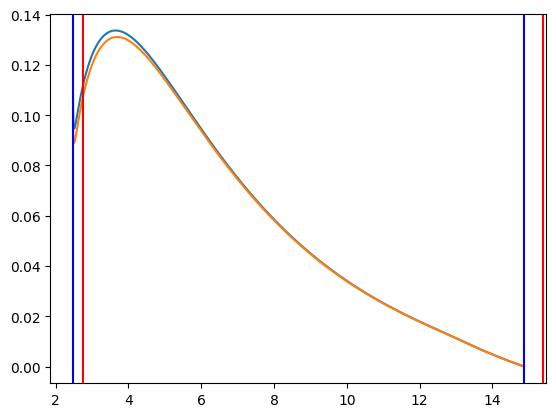

In [203]:
plt.plot(K1p,RPl_u)
plt.plot(K1p,RP1_u)
plt.axvline(KL,color='r')
plt.axvline(KR,color='r')
plt.axvline(Kl,color='b')
plt.axvline(Kr,color='b')

In [368]:
np.nanmin(RP1_us)

0.00019725240981435717

In [252]:
RPl = np.where(np.array(RPl_us) - np.array(RP1_us)>0,np.array(RPl_us),np.nan)
RP = np.where(np.array(RPl_us) - np.array(RP1_us)>0,np.array(RP1_us),np.nan)

In [268]:
ms_ = np.linspace(0,10,1001)

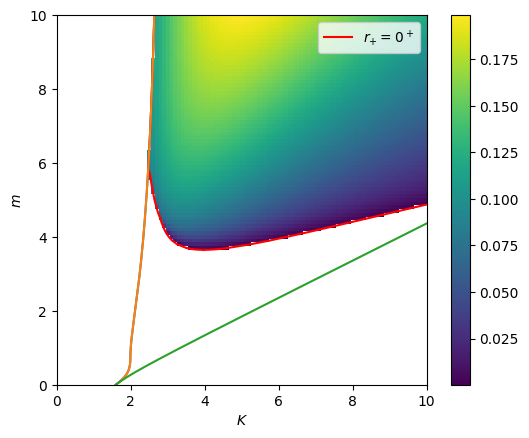

In [269]:
plt.pcolormesh(KK,MM,RP.T)
plt.gca().set_aspect('equal')

plt.plot(K_rp0d,ms_rp0,'r-',label=r'$r_{+}=0^+$')
plt.plot(K_rp0u,ms_rp0,'r-')

plt.plot(K_mins,ms_)
plt.plot(Kcs,ms_)

# plt.plot(Ks_d_rpl0,ms_rpl0,'b-',label=r'$r_{+l}=0^+$')
# plt.plot(Ks_u_rpl0,ms_rpl0,'b-')

# plt.plot(Ks_d_rd,ms_rd,'g-',label=r'$r_{+}=-r_d/2$')
# plt.plot(Ks_u_rd,ms_rd,'g-')
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel(r'$K$')
plt.ylabel(r'$m$')
plt.legend()
plt.colorbar()
plt.show()


In [227]:
def get_K_min(m):
    Xs1 = np.logspace(-15,-3,2000)
    Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]
    R_ls = []
    R_drs = []

    for X in Xs:
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        R_ls.append(R_l)
        R_drs.append(R_dr)


    R0 = np.array(R_ls)
    RD = 2*np.array(R_drs)
    R = R0 -RD
    KK = 1/(R/Xs)
    return np.min(KK),KK[0]


In [180]:
def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=200)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan


In [218]:
RP1_d = []
RP1_u = []
RPl_d = []
RPl_u = []
K1p = []
for X, K, r, r0, rd, OP in zip(Xsu, K_u, R_u, R_0u, R_du, OPS):
    # 1. 적당한 간격으로 샘플
    rps = np.r_[np.logspace(-18, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
    diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]

    try:
        # 첫 번째 교점
        i1 = sign_change[0]
        rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))

        # 두 번째 교점
        i2 = sign_change[-1]
        rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

        RP1_d.append(rp_left)
        RP1_u.append(rp_right)

        # RP값도 같이 저장
        RPl_d.append(RP_l(rp_left, K, r0, OP, m))
        RPl_u.append(RP_l(rp_right, K, r0, OP, m))
        K1p.append(K)
    except:
        K1p.append(K)
        RP1_d.append(np.nan)
        RP1_u.append(np.nan)
        RPl_d.append(np.nan)
        RPl_u.append(np.nan)


/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_69480/3468341370.py:11: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_69480/3468341370.py:29: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)


In [219]:
K1p = np.array(K1p)
RP1_u = np.array(RP1_u)
RPl_u = np.array(RPl_u)
RP1_d = np.array(RP1_d)
RPl_d = np.array(RPl_d)


arg, = np.where(RP1_u<1e-13)
K1p[arg] = np.nan
RPl_u[arg] = np.nan
RP1_u[arg] = np.nan
RPl_d[arg] = np.nan
RP1_d[arg] = np.nan



In [220]:
K_u == K1p

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
K_ = np.linspace(0,10,101)
m_ = np.linspace(0,10,101)
R_us = []
R_0us = []
RP1_us = []
RPl_us = []
for m in tqdm(m_):
    R_u,R_0u,RP1_u,RPl_u = get_K_r_rp(m,K_)
    R_us.append(R_u)
    R_0us.append(R_0u)
    RP1_us.append(RP1_u)
    RPl_us.append(RPl_u)

In [220]:
np.savez('Simul/RR_RP.npz',RP=RP,RPl=RPl,R=R_us,R0=R_0us,Ks=K_,ms=m_,allow_pickle=True)

In [ ]:
np.savez('Simul/R_Kc.npz',ms = ms,Kcs = Kcs,K_mins = K_mins,allow_pickle=True)

In [231]:
np.savez('Simul/mcs_rp0.npz',ms=ms_rp0,K_u=K_rp0u,K_d=K_rp0d)

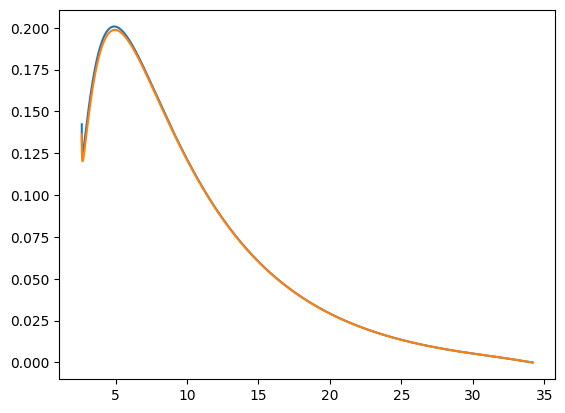

In [221]:
plt.plot(K1p,RPl_u)
# plt.plot(K1p,RPl_d)
plt.plot(K1p,RP1_u)

In [102]:
# plt.plot(K1p,RPl_u - RP1_u)
# plt.plot(K1p,RP1_u)

# plt.plot(KK,R)

# plt.plot(K1p,RPl_d)
# plt.plot(K1p,RP1_d)

In [228]:
ms = np.linspace(0,10,1001)

K_mins = []
Kcs = []
for m in tqdm(ms):
    K_min,Kc = get_K_min(m)
    K_mins.append(K_min)
    Kcs.append(Kc)


  0%|          | 0/1001 [00:00<?, ?it/s]

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/1595263042.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  a = 1/np.sqrt(X*m)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_13680/1595263042.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  b = 4/np.pi * a - 0.3056*a**3


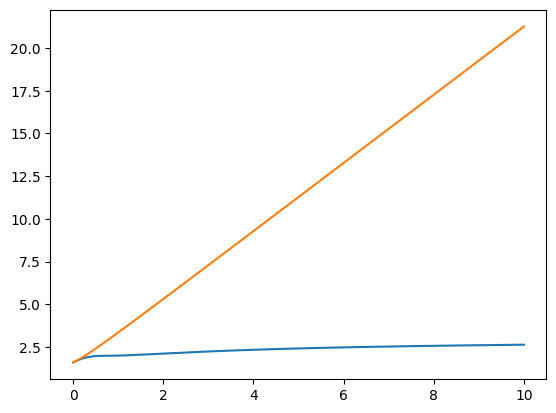

In [229]:
ms = np.linspace(0,10,1001)

plt.plot(ms,K_mins)
plt.plot(ms,Kcs)

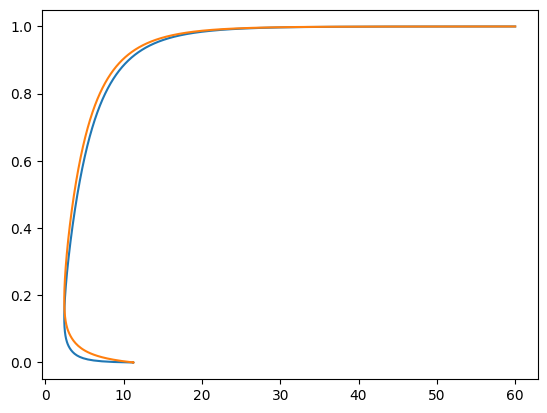

In [10]:
plt.plot(KK,R)
plt.plot(KK,R0)

In [234]:
N = 5000
df_new = pd.read_excel(f'N = {N} seed = 10 QNORMAL wo pv.xlsm',index_col=[0,1])

In [239]:
loaded_data['RP']

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.12011114, 0.11847231,
        0.1168507 ],
       [       nan,        nan,        nan, ..., 0.12222518, 0.12057868,
        0.11894906],
       [       nan,        nan,        nan, ..., 0.12432975, 0.122676  ,
        0.12103879]])

In [245]:
# 저장된 npz 파일 로드
loaded_data = np.load('Simul/RR_RP.npz', allow_pickle=True)
# 딕셔너리로 변환
# RR = dict(loaded_data.item())  # .item()을 사용해 원래 딕셔너리로 변환

Ks = np.arange(0,10.01,0.1)
ms = np.arange(0,10.02,0.1)
KK,MM = np.meshgrid(Ks,ms,indexing='ij')


In [ ]:
# A_RPU = pd.DataFrame(df['u']['rp'],index=Ks).to_numpy(dtype=float)
# A_RPD = pd.DataFrame(df['d']['rp'],index=Ks).to_numpy(dtype=float)
# A_RPU0 = pd.DataFrame(df['u']['rp0'],index=Ks).to_numpy(dtype=float)
# A_RPD0 = pd.DataFrame(df['d']['rp0'],index=Ks).to_numpy(dtype=float)
# A_RM = pd.DataFrame(df['u']['R'],index=Ks).to_numpy(dtype=float)
# A_R0 = pd.DataFrame(df['u']['R0'],index=Ks).to_numpy(dtype=float)
# A_SIG = pd.DataFrame(df['u']['SIG'],index=Ks).to_numpy(dtype=float)
# A_RDrH = (A_R0 - A_RM)/2



NRP = df_new['r+'].unstack().to_numpy(float)
NRPT = df_new['r+_total'].unstack().to_numpy(float)
NR0 = df_new['r0'].unstack().to_numpy(float)
NRM = df_new['r-'].unstack().to_numpy(float)
NRMT = df_new['r-_total'].unstack().to_numpy(float)
NSIG_S = df_new['sig'].unstack().to_numpy(float)

In [275]:
RP0

NameError: name 'RP0' is not defined

In [ ]:
R_u,R_0u,RP1_u,RPl_u = get_K_r_rp(m,K_)
R_us.append(R_u)
R_0us.append(R_0u)
RP1_us.append(RP1_u)
RPl_us.append(RPl_u)

In [276]:
A_RPU = np.array(RP1_us).T#(df['u']['rp'],index=Ks).to_numpy(dtype=float)
A_RPU0 = np.array(RPl_us).T
A_RM = np.array(R_us).T
A_R0 = np.array(R_0us).T
# A_SIG = pd.DataFrame(df['u']['SIG'],index=Ks).to_numpy(dtype=float)
A_RDrH = (A_R0 - A_RM)/2


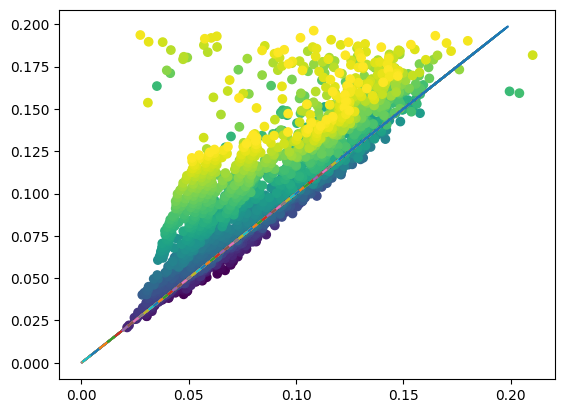

In [272]:
plt.scatter(NRP,RP.T,c=MM)
plt.plot(RP.T,RP.T)

In [ ]:
K_ = np.linspace(0,10,101)
m_ = np.linspace(0,10,101)
R_us = []
R_0us = []
RP1_us = []
RPl_us = []
for m in tqdm(m_):
    R_u,R_0u,RP1_u,RPl_u = get_K_r_rp(m,K_)
    R_us.append(R_u)
    R_0us.append(R_0u)
    RP1_us.append(RP1_u)
    RPl_us.append(RPl_u)

In [ ]:
A_RPU = np.array(RP1_us)
A_R0 = np.array(R_0us)
A_RM = R_u
A_RDrH = (A_R0 - A_RM)/2

In [247]:
ms_ = np.linspace(0,10,1001)

Text(0, 0.5, '$m$')

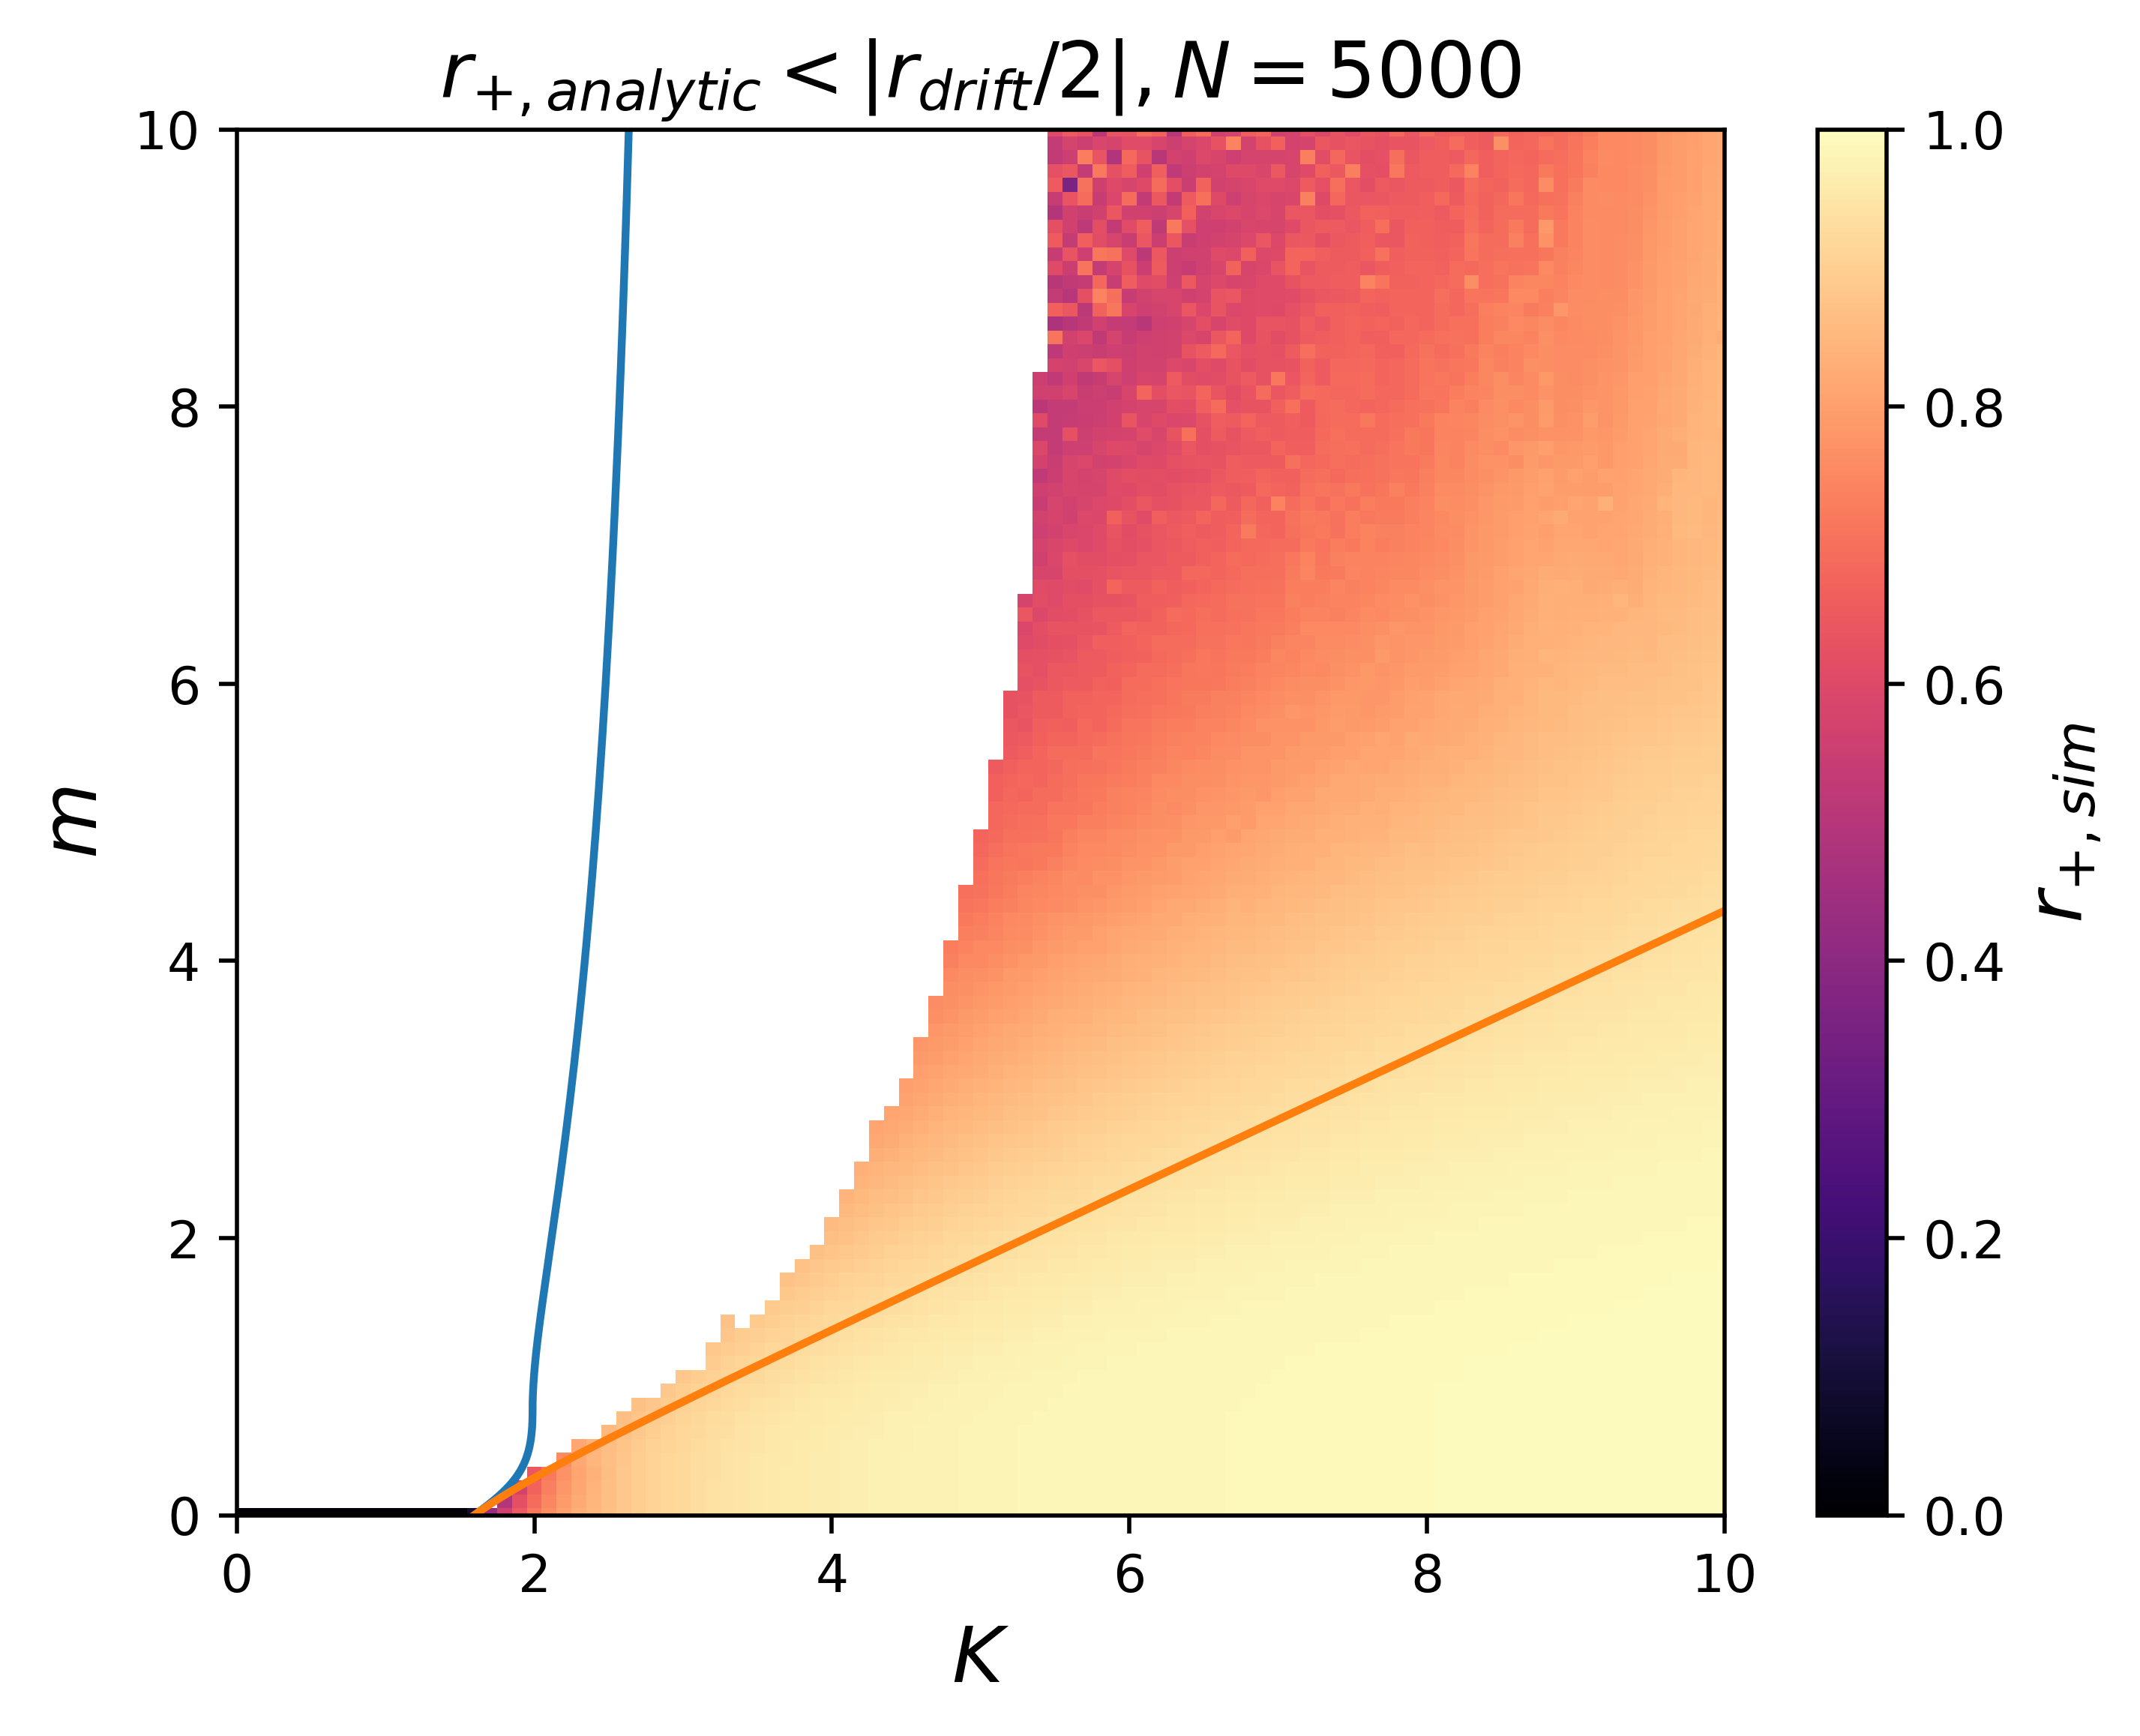

In [249]:
plt.figure(dpi=500)
# X = np.isnan(A_RPU)
# Y = A_RPU>=A_RDrH
# Z = np.isnan(R0)
plt.pcolormesh(KK,MM,R0,cmap='magma',vmin=0,vmax=1)
plt.plot(K_mins,ms_)
plt.plot(Kcs,ms_)
cbar = plt.colorbar(label=r'$r_{+,sim}$')
# cbar.ax.tick_params(labelsize=12)  # Adjust the font size of the colorbar ticks
cbar.set_label(r'$r_{+,sim}$', fontsize=15)  # Set the font size of the colorbar label
# plt.title(r'$r_{0,sim}>0.1$',fontsize=15)
plt.title(r'$r_{+,analytic}<|r_{drift}/2|,N = {5000}$',fontsize=15)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('$K$',fontsize=15)
plt.ylabel('$m$',fontsize=15)


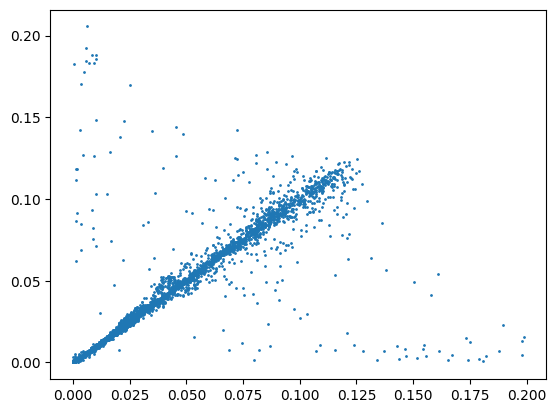

In [30]:
plt.scatter(abs((A_RDrH.T-RMT.T).flatten()),abs((A_RDrH.T-RPT.T).flatten()),s=1)


In [273]:
RR

array([6.26672359e-16, 6.35394631e-16, 6.44238303e-16, ...,
       9.99861027e-01, 9.99861054e-01, 9.99861082e-01])

Text(0, 0.5, '$m$')

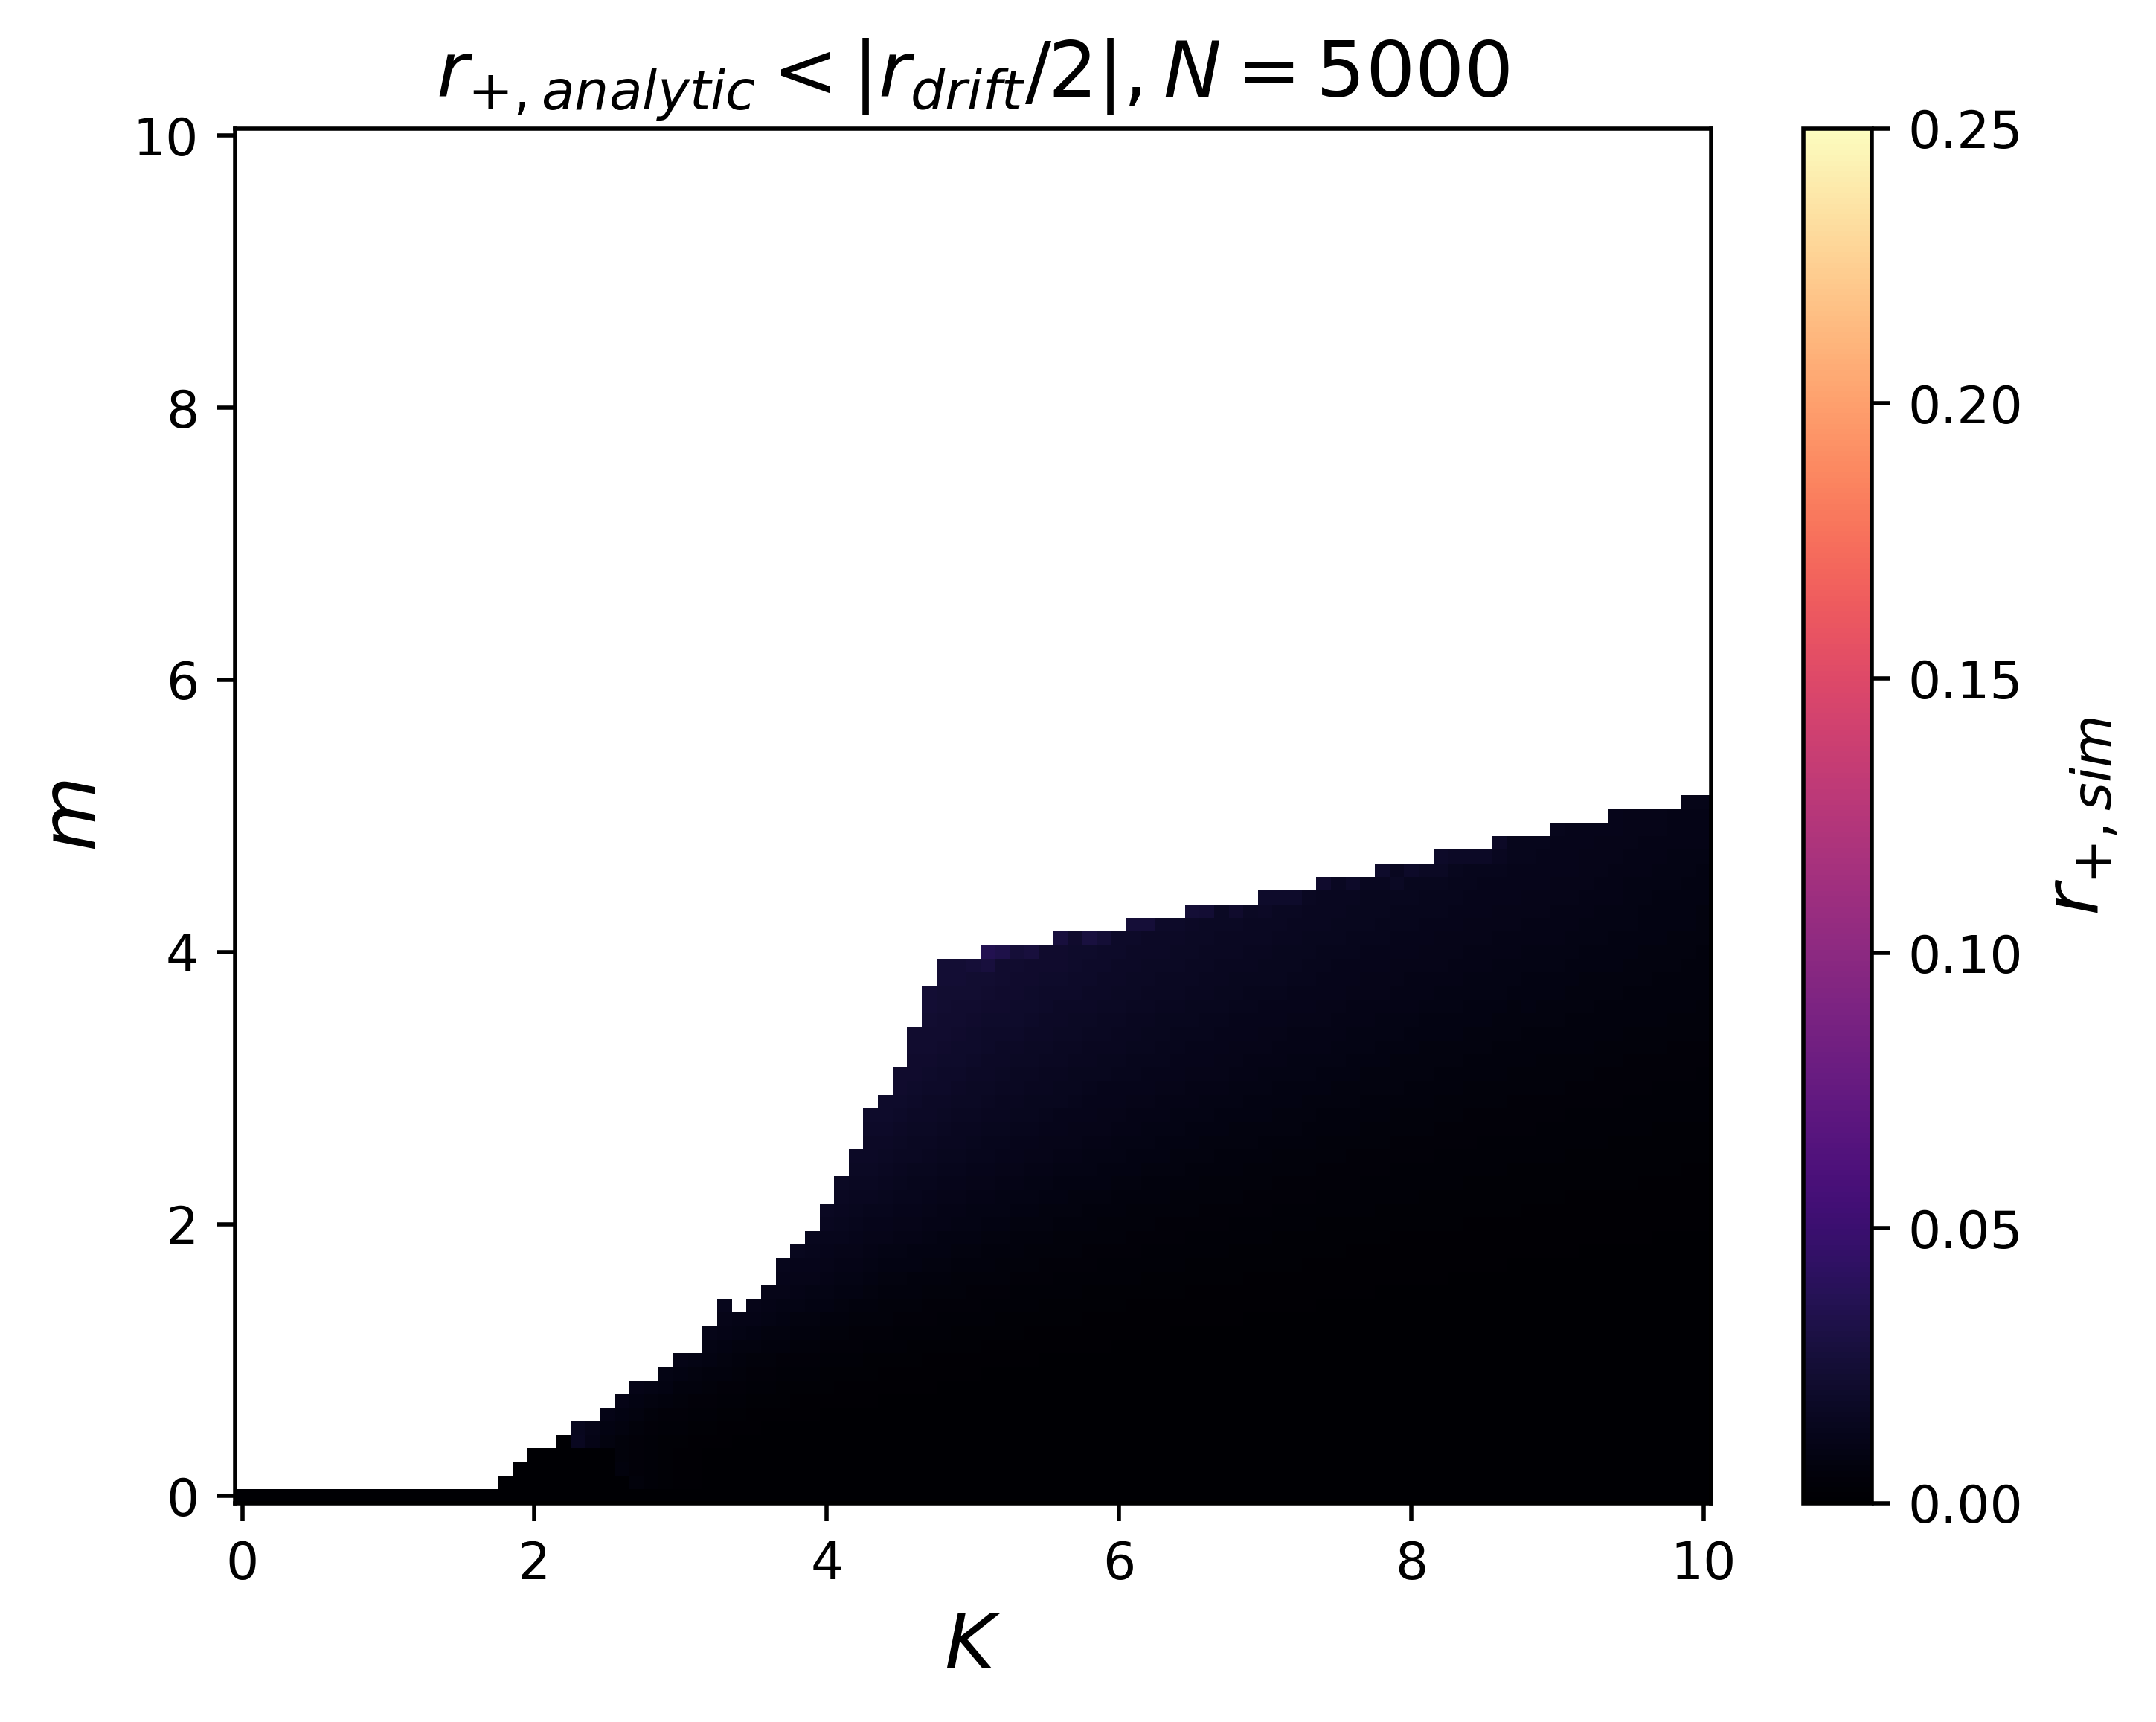

In [277]:
plt.figure(dpi=500)
X = np.isnan(RP.T)
Y = A_RPU>=A_RDrH
Z = np.isnan(R0)
plt.pcolormesh(KK,MM,np.where(~Z&~Y,RPT,np.nan),cmap='magma',vmin=0,vmax=0.25)
cbar = plt.colorbar(label=r'$r_{+,sim}$')
# cbar.ax.tick_params(labelsize=12)  # Adjust the font size of the colorbar ticks
cbar.set_label(r'$r_{+,sim}$', fontsize=15)  # Set the font size of the colorbar label
# plt.title(r'$r_{0,sim}>0.1$',fontsize=15)
plt.title(r'$r_{+,analytic}<|r_{drift}/2|,N = {5000}$',fontsize=15)

plt.xlabel('$K$',fontsize=15)
plt.ylabel('$m$',fontsize=15)


Text(0, 0.5, '$m$')

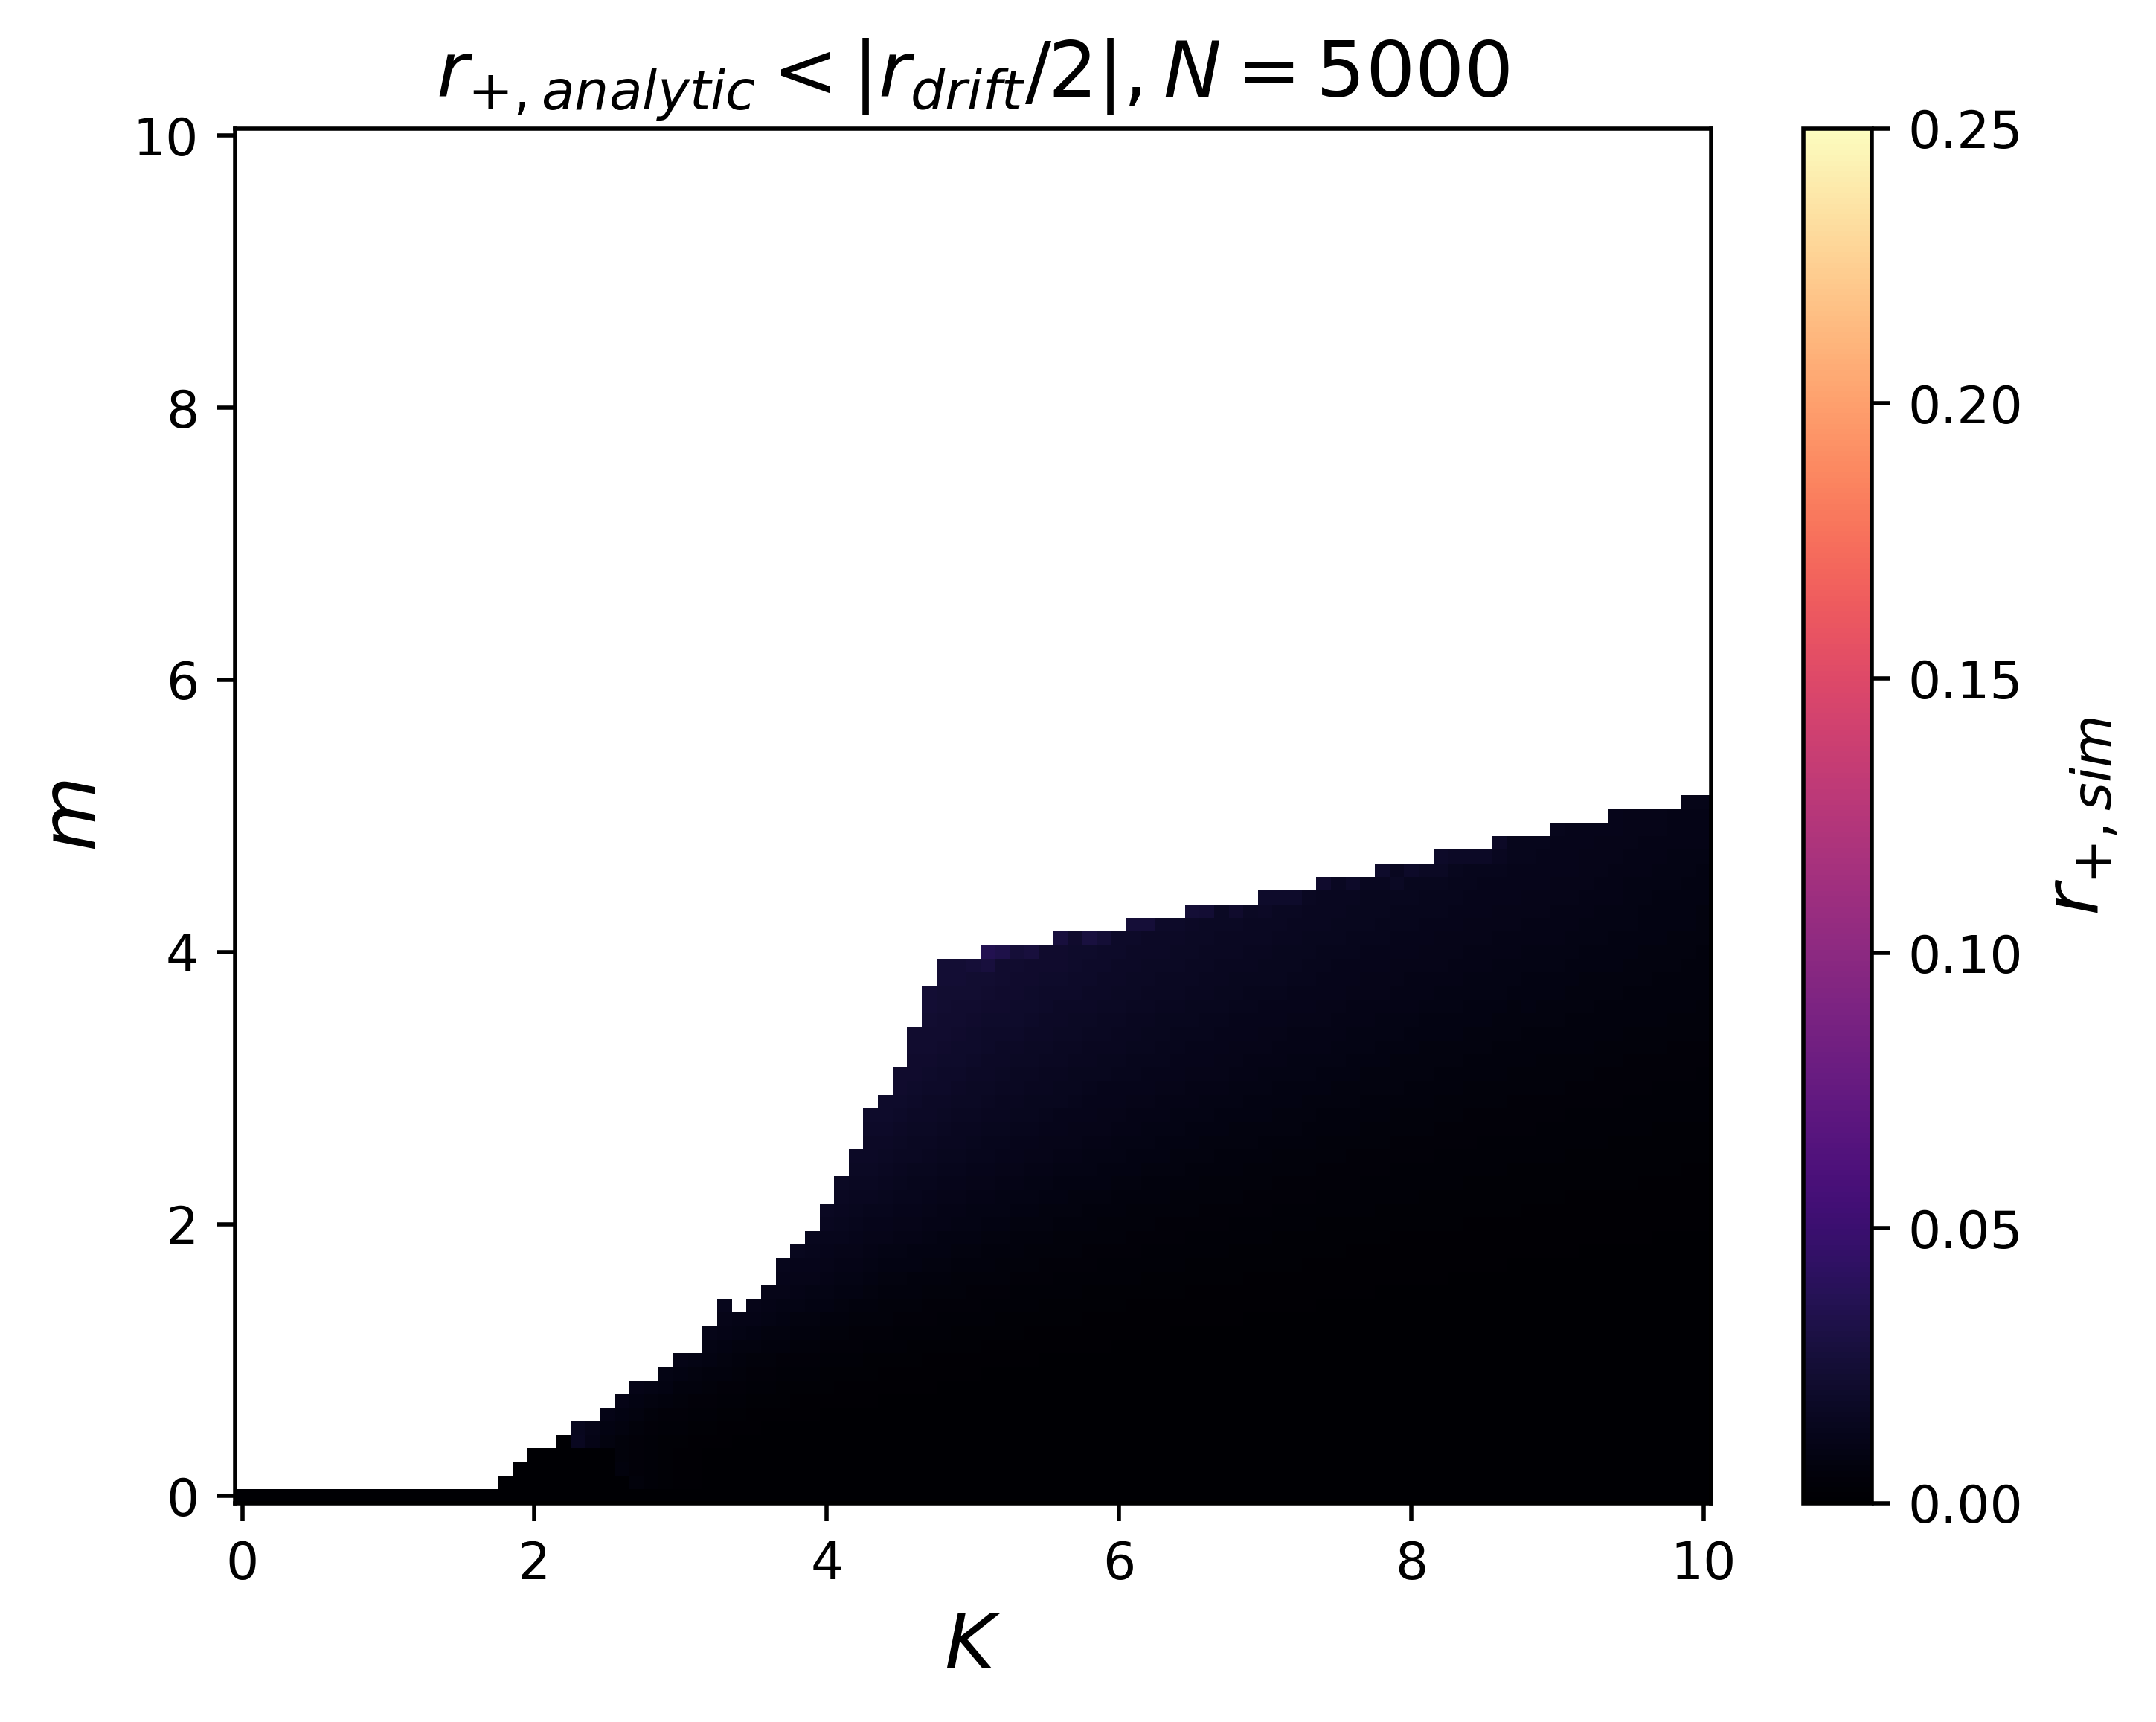

In [ ]:
plt.figure(dpi=500)
X = np.isnan(A_RPU)
Y = A_RPU>=A_RDrH
Z = np.isnan(R0)
plt.pcolormesh(KK,MM,np.where(~Z&~Y,RPT,np.nan),cmap='magma',vmin=0,vmax=0.25)
cbar = plt.colorbar(label=r'$r_{+,sim}$')
# cbar.ax.tick_params(labelsize=12)  # Adjust the font size of the colorbar ticks
cbar.set_label(r'$r_{+,sim}$', fontsize=15)  # Set the font size of the colorbar label
# plt.title(r'$r_{0,sim}>0.1$',fontsize=15)
plt.title(r'$r_{+,analytic}<|r_{drift}/2|,N = {5000}$',fontsize=15)

plt.xlabel('$K$',fontsize=15)
plt.ylabel('$m$',fontsize=15)


In [284]:
A_R0P = A_R0 + 2 * A_RPU0
S_R0P = NR0 + NRP + NRM

In [287]:
plt.plot(Ks,DRP_AS[:,70])
plt.plot(Ks,R0_SA[:,70])
plt.plot(Ks,NRPU[:,70])
plt.plot(Ks,NRP[:,70])
plt.plot(Ks,NR0[:,70])
plt.plot(Ks,NR0A[:,70])

NameError: name 'DRP_AS' is not defined

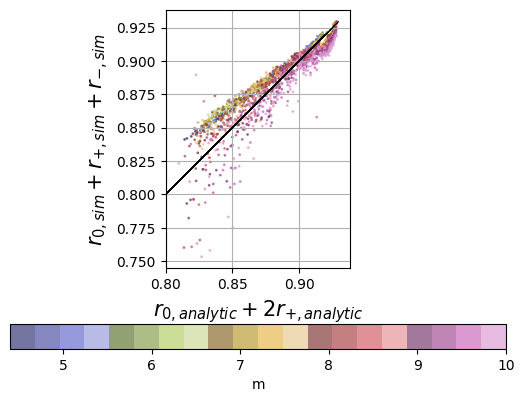

In [282]:
plt.scatter(A_R0P.flatten(),S_R0P.flatten(),s=1,c=MM.flatten(),alpha=0.7,cmap='tab20b')
plt.plot(S_R0P.flatten(),S_R0P.flatten(),c='k',lw=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0.8,)
plt.ylabel(r'$r_{0,sim}+r_{+,sim}+r_{-,sim}$',fontsize=15)
plt.xlabel(r'$r_{0,analytic}+2r_{+,analytic}$',fontsize=15)
plt.colorbar(label='m',orientation='horizontal')
plt.grid()

Text(0.5, 1.0, '$r_{+,analytic}<|r_{drift}/2|,N = {5000}$')

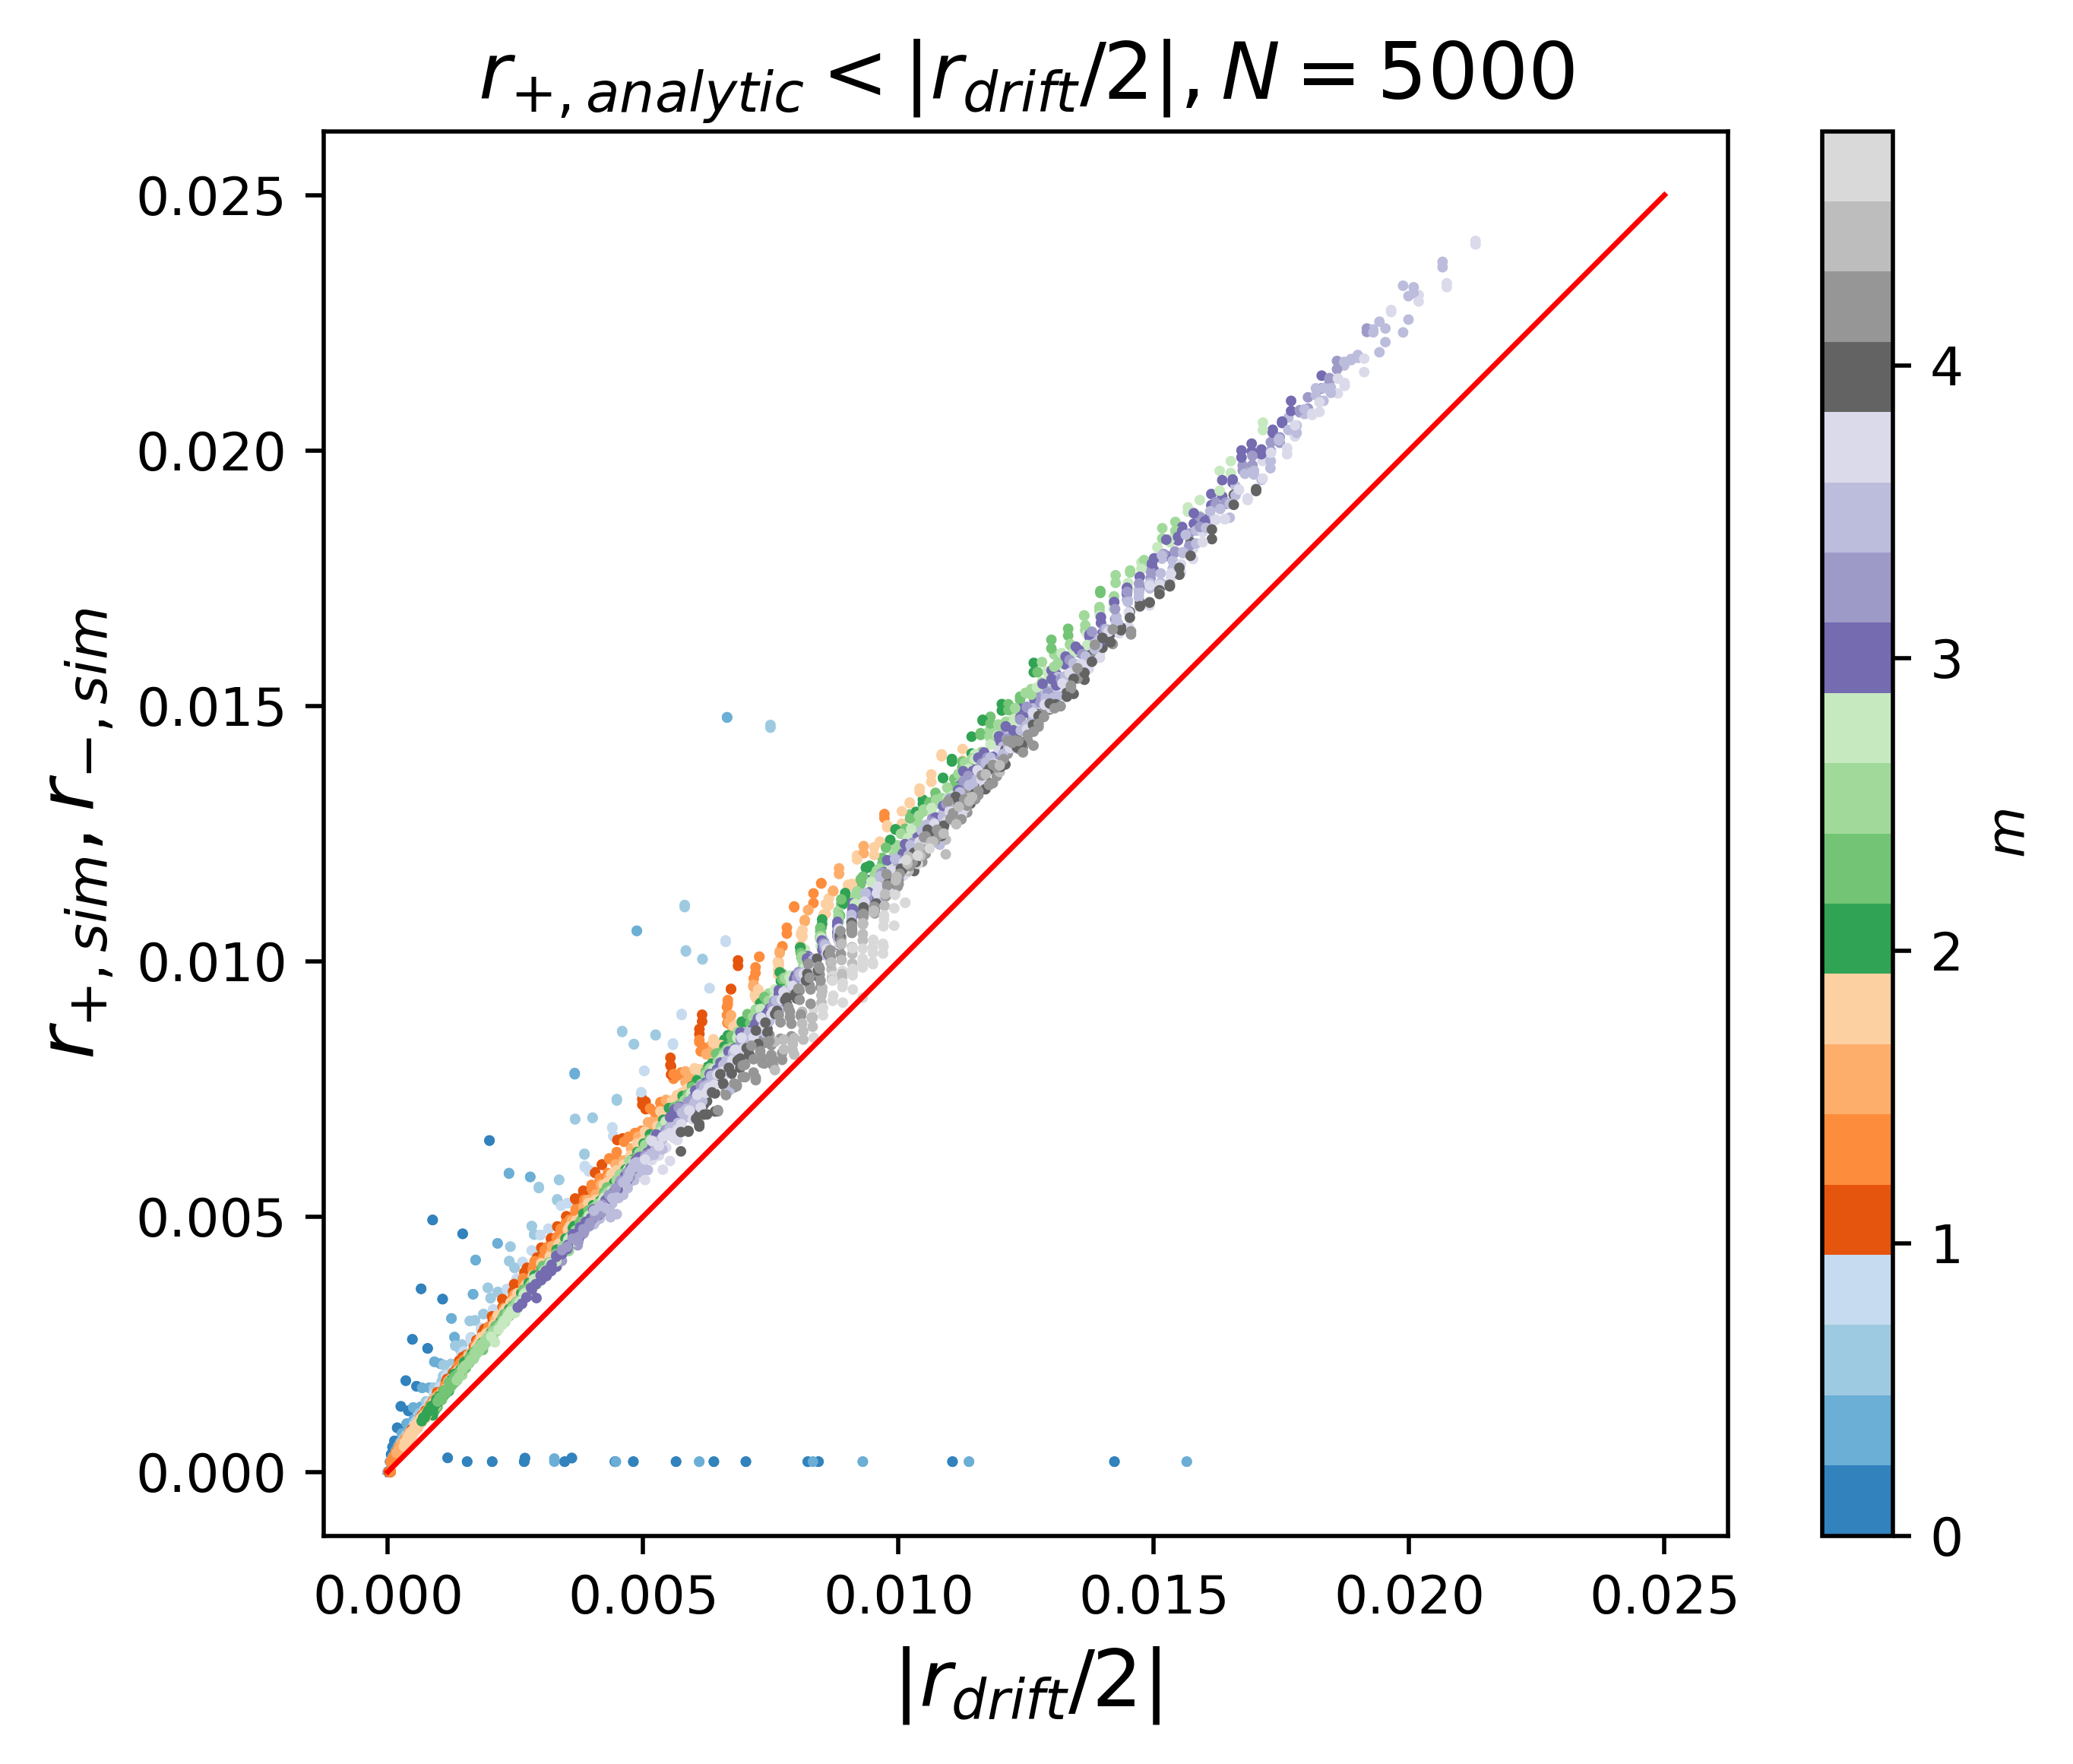

In [278]:
plt.figure(dpi=500)
plt.scatter(A_RDrH[X&~Y&~Z].T.flatten(),((RMT)[X&~Y&~Z]).T.flatten(),c=MM[X&~Y&~Z].T,s=1,cmap='tab20c')
plt.scatter(A_RDrH[X&~Y&~Z].T.flatten(),((RPT)[X&~Y&~Z]).T.flatten(),c=MM[X&~Y&~Z].T,s=1,cmap='tab20c')
# plt.ylim(-0.02,0.02)
plt.plot([0,0.025],[0,0.025],color='red',lw=1)
# plt.ylim(0, np.nanmax(A_RDrH[X&~Y&~Z].T.flatten()))
# plt.xlim(0, np.nanmax(A_RDrH[X&~Y&~Z].T.flatten()))
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(label='$m$')
plt.xlabel('$|r_{drift}/2|$',fontsize=15)
plt.ylabel('$r_{+,sim},r_{-,sim}$',fontsize=15)
plt.title(r'$r_{+,analytic}<|r_{drift}/2|,N = {5000}$',fontsize=15)